In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def display_image(title, image, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

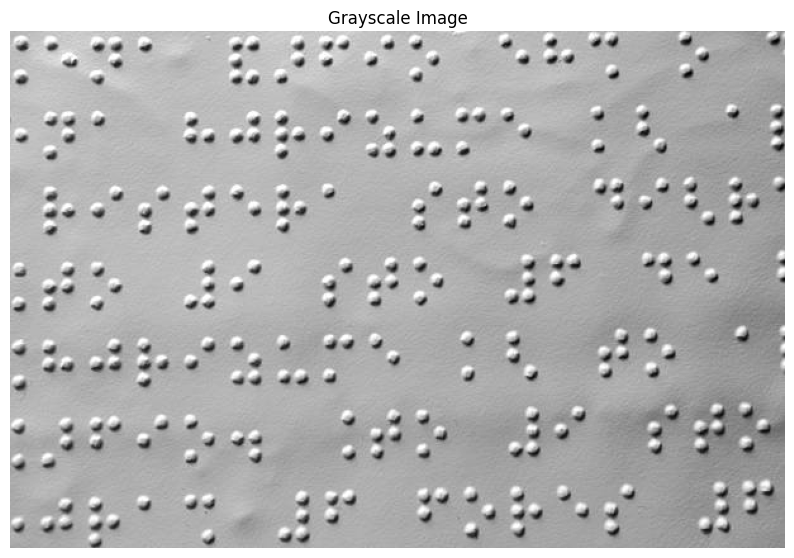

In [10]:
# Step 1: Import and Preprocess the Image
img = cv2.imread('./raw_dataset/img9.jpg')
if img is None:
    raise FileNotFoundError(f"Image not found at {'./raw_dataset/img9.jpg'}")
image = img.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display_image("Grayscale Image", gray)

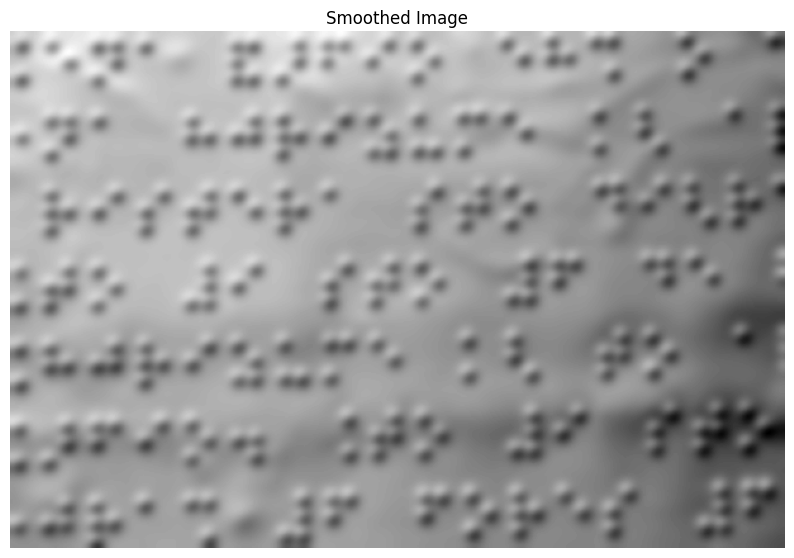

In [11]:
# Noise Reduction
smoothed = cv2.GaussianBlur(gray, (27, 27), 0)
display_image("Smoothed Image", smoothed)

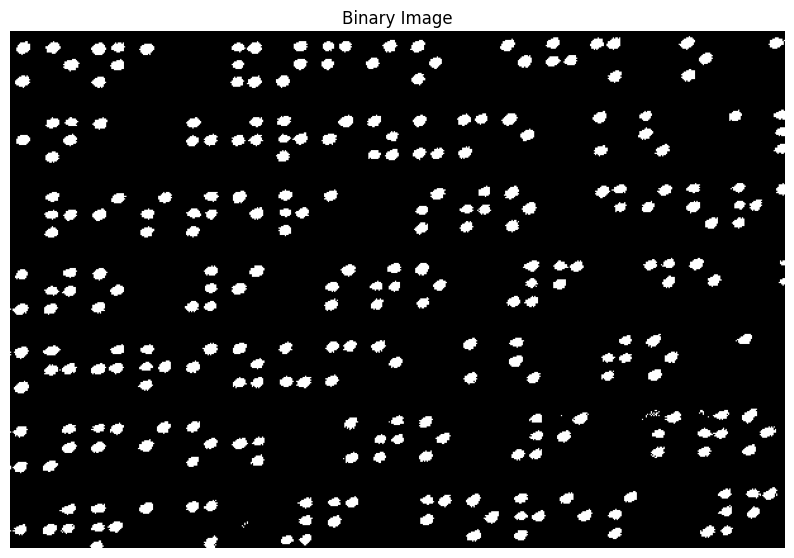

In [12]:
# Step 3: Segment the Braille Characters
binary = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
display_image("Binary Image", binary)

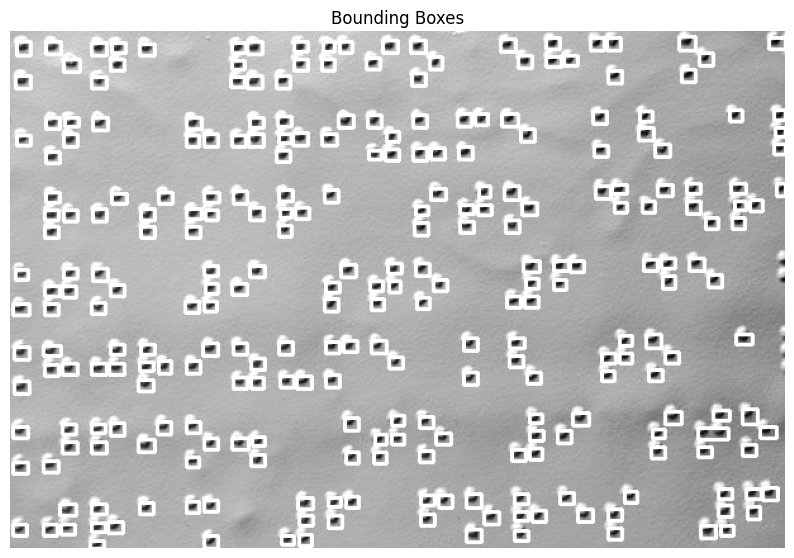

In [13]:
dot_contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and Display Contours
output = gray.copy()
min_width, min_height = 5, 5  # Adjust based on Braille dot size
cropped_images = []

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > min_width and h > min_height:
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cropped = gray[y:y + h, x:x + w]
        cropped_images.append(cropped)

# Display the image with bounding boxes
display_image("Bounding Boxes", output)

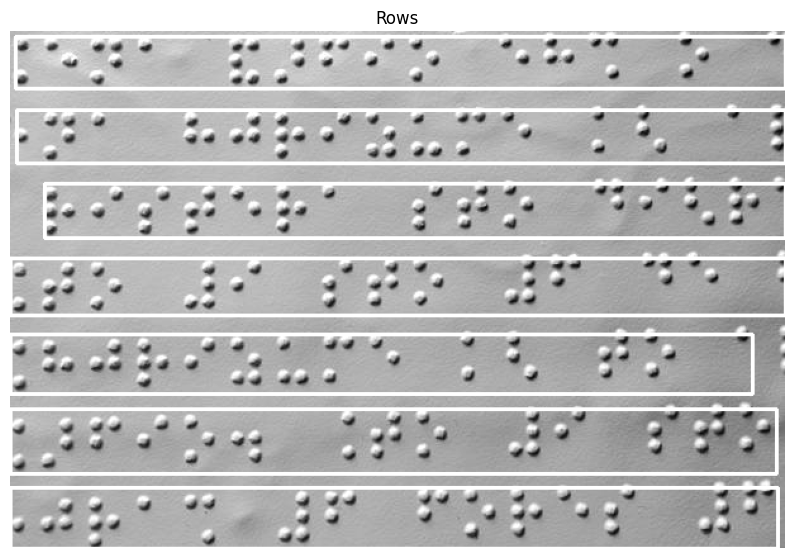

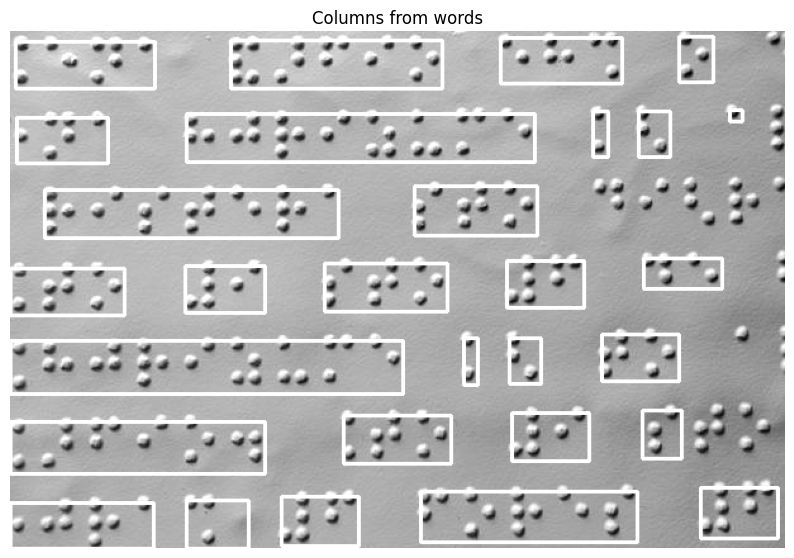

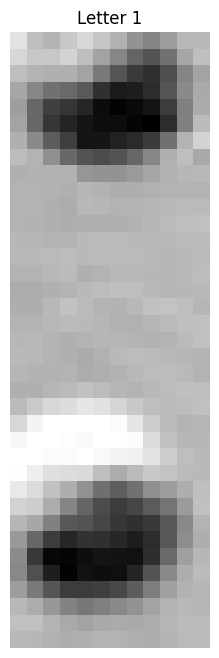

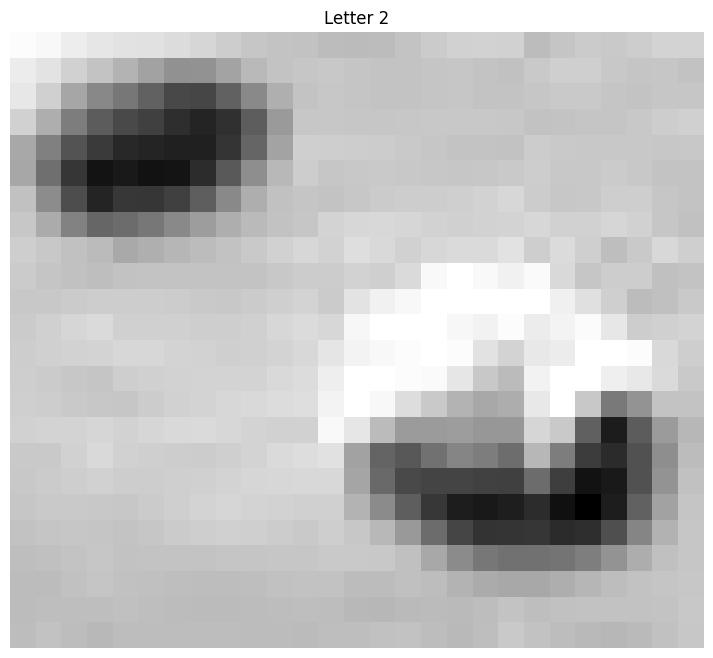

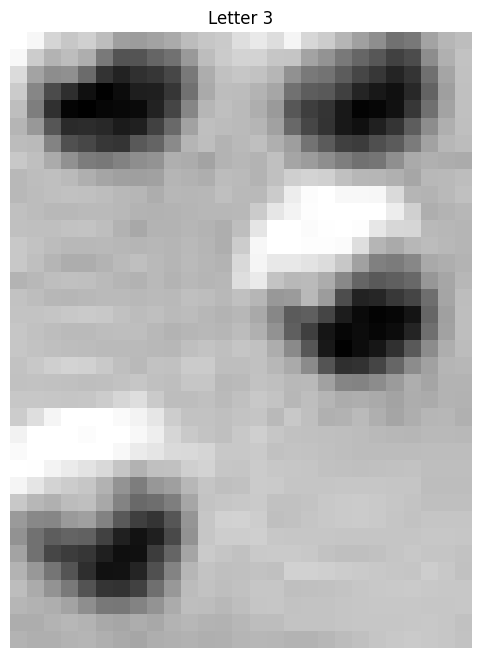

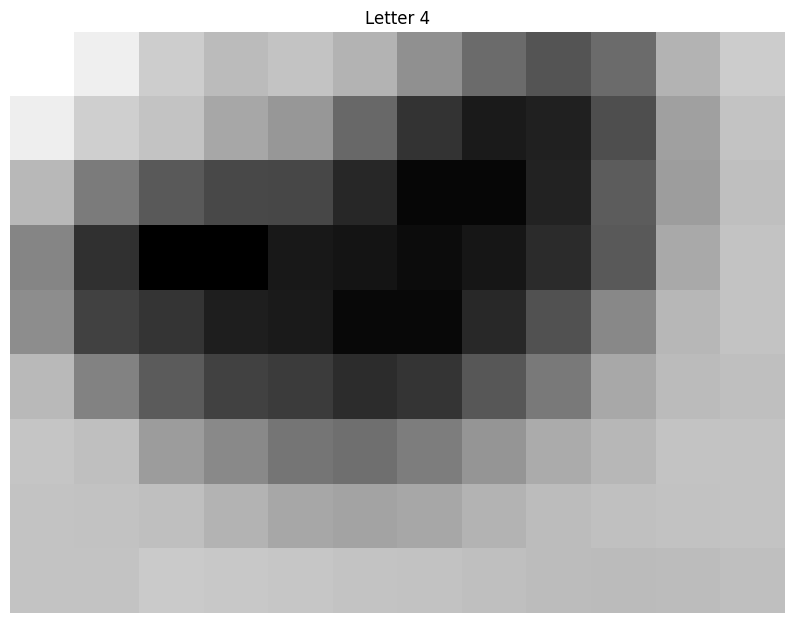

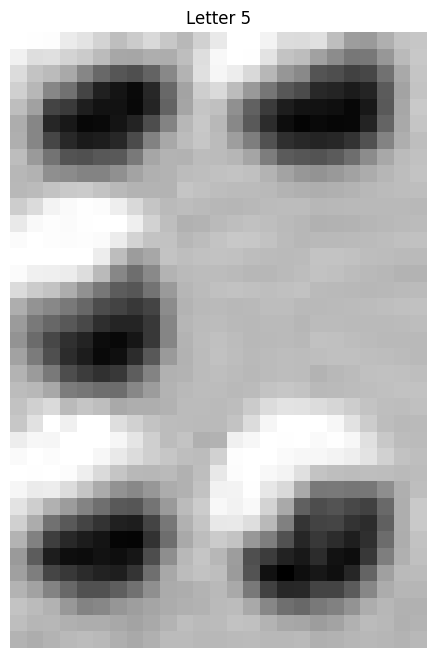

In [14]:
import numpy as np

# Parameters (adjust based on Braille dot size and spacing)
# We will start with 20*20 but we will make it dynamic later
dot_spacing_threshold = 20  # Distance threshold to group dots into a row
word_spacing_threshold = 30 # Distance threshold to group rows into a word
letter_spacing_threshold = 20  # Distance threshold to group rows into letters

# Sort contours by y, then x
dot_contours = sorted(dot_contours, key=lambda cnt: (cv2.boundingRect(cnt)[1], cv2.boundingRect(cnt)[0]))

# Group dots into rows
rows = []
current_row = []
previous_y = None

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    center_y = y + h // 2

    if previous_y is None or abs(center_y - previous_y) < dot_spacing_threshold:
        current_row.append((x, y, w, h))
    else:
        rows.append(current_row)
        current_row = [(x, y, w, h)]
    previous_y = center_y

if current_row:
    rows.append(current_row)

# Display the extracted letters
output2 = gray.copy()
for row in rows:
    min_x = min([x for x, y, w, h in row])
    min_y = min([y for x, y, w, h in row])
    max_x = max([x + w for x, y, w, h in row])
    max_y = max([y + h for x, y, w, h in row])
    cv2.rectangle(output2, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Rows", output2)


# Group rows into words
words = []
for row in rows:
    row = sorted(row, key=lambda b: b[0]) 
    current_word = []
    prev_x = None

    for bbox in row:
        x, y, w, h = bbox
        center_x = x + w // 2

        if prev_x is None or abs(center_x - prev_x) < word_spacing_threshold:
            current_word.append(bbox)
        else:
            words.append(current_word)
            current_word = [bbox]
        prev_x = center_x
    prev_x = center_x
if current_word:
    words.append(current_word)

output_words = gray.copy()
for word in words:
    min_x = min([x for x, y, w, h in word])
    min_y = min([y for x, y, w, h in word])
    max_x = max([x + w for x, y, w, h in word])
    max_y = max([y + h for x, y, w, h in word])
    cv2.rectangle(output_words, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Columns from words", output_words)

# Group rows into letters
letters = []
for row in rows:
    row = sorted(row, key=lambda b: b[0])  # Sort by x-coordinate
    current_letter = []
    previous_x = None

    for bbox in row:
        x, y, w, h = bbox
        center_x = x + w // 2

        if previous_x is None or abs(center_x - previous_x) < letter_spacing_threshold:
            current_letter.append(bbox)
        else:
            letters.append(current_letter)
            current_letter = [bbox]
        previous_x = center_x

    if current_letter:
        letters.append(current_letter)

# Extract and save each letter
letter_images = []
for letter in letters:
    # Find the bounding box for the entire letter
    min_x = min([x for x, y, w, h in letter])
    min_y = min([y for x, y, w, h in letter])
    max_x = max([x + w for x, y, w, h in letter])
    max_y = max([y + h for x, y, w, h in letter])

    # Crop the letter region
    letter_image = gray[min_y:max_y, min_x:max_x]
    letter_images.append(letter_image)

# Display the extracted letters
for i, letter_image in enumerate(letter_images):
    display_image(f"Letter {i+1}", letter_image)
    if i == 4:
        break


In [31]:
def normalize_to_grid(letter_bboxes, grid_size=(3, 2)):
    min_x = min(bbox[0] for bbox in letter_bboxes)
    min_y = min(bbox[1] for bbox in letter_bboxes)
    max_x = max(bbox[0] + bbox[2] for bbox in letter_bboxes)
    max_y = max(bbox[1] + bbox[3] for bbox in letter_bboxes)
    
    width = max_x - min_x
    height = max_y - min_y
    
    grid = np.zeros(grid_size, dtype=int)
    
    for x, y, w, h in letter_bboxes:
        col = int(grid_size[1] * (x - min_x) / width)
        row = int(grid_size[0] * (y - min_y) / height)
        grid[row, col] = 1
    
    return grid

print(normalize_to_grid([words[0][4], words[0][5]], (3, 2)))

[[1 0]
 [0 0]
 [1 0]]


In [15]:
words[0]

[(4, 35, 12, 10),
 (5, 8, 11, 11),
 (28, 8, 12, 10),
 (42, 22, 13, 10),
 (64, 9, 12, 10),
 (64, 36, 12, 9),
 (79, 22, 11, 9),
 (80, 9, 11, 8),
 (102, 10, 12, 9)]

In [29]:
def braille_matrix_to_unicode(matrix):
    """
    Converts a 3x2 binary Braille matrix to a Braille Unicode character.
    
    Args:
        matrix (np.ndarray): A 3x2 matrix with 1s and 0s.
    
    Returns:
        str: A single Braille Unicode character representing the matrix.
    """
    # Ensure the matrix is 3x2
    assert matrix.shape == (3, 2), "Matrix must be 3x2 in shape."
    
    # Map the Braille matrix to the corresponding Unicode value
    # Dots correspond to binary positions: 1, 2, 3, 4, 5, 6 (top to bottom, left to right)
    braille_offset = 0x2800  # Unicode offset for Braille characters
    binary_value = (
        (matrix[0, 0] << 0) |  # Dot 1
        (matrix[1, 0] << 1) |  # Dot 2
        (matrix[2, 0] << 2) |  # Dot 3
        (matrix[0, 1] << 3) |  # Dot 4
        (matrix[1, 1] << 4) |  # Dot 5
        (matrix[2, 1] << 5)    # Dot 6
    )
    
    # Convert to Unicode Braille character
    braille_char = chr(braille_offset + binary_value)
    return braille_char
braille_matrix_to_unicode(np.array([[1, 0], [0, 0], [1, 0]]))

'⠅'

In [25]:
# Import the Braille-to-Amharic dictionary
from letters import AMHARIC_ALPHABET, NUMBERS, SYMBOLS 

def braille_to_amharic(braille_base, braille_modifier):
    """
    Converts a 3x2 Braille matrix to its corresponding Amharic character.
    
    Args:
        matrix (np.ndarray): A 3x2 matrix with 1s and 0s.
    
    Returns:
        str: The corresponding Amharic character or a placeholder if not found.
    """
    # Check if the base character exists in the dictionary
    if braille_base in AMHARIC_ALPHABET:
        # Check if the modifier exists for this base character
        return AMHARIC_ALPHABET[braille_base].get(braille_modifier, "�")
    elif braille_base in SYMBOLS:
        # Base character not found
        return SYMBOLS[braille_base]
    elif braille_base in NUMBERS:
        return NUMBERS[braille_base]

In [26]:
len(letters)

99

In [41]:
amhar_words = []
for word in words:
    m = len(word) % 4
    if len(word) % 4 == 0:
        word = word
    else:
        word = word[:-m]
    amh_word = ""
    for i in range(0, len(word), 4):
        base =[word[i], word[i+1]]  # Base character
        modifier = [word[i+2], word[i+3]]  # Modifier character

        # Normalize to 3x2 grids
        normalized_base = normalize_to_grid(base)
        normalized_modifier = normalize_to_grid(modifier)

        # Convert grids to Unicode Braille characters
        braille_base = braille_matrix_to_unicode(normalized_base)
        braille_modifier = braille_matrix_to_unicode(normalized_modifier)
        # if braille_modifier == "⠼":
        #     braille_modifier = "⠑"
        # Map Braille characters to Amharic
        amharic_char = braille_to_amharic(braille_base, braille_modifier)
        if amharic_char == None:
            amharic_char = "."
        amh_word += amharic_char

        # print(f"Base Matrix:\n{normalized_base}")
        # print(f"Modifier Matrix:\n{normalized_modifier}")
        # print(f"Braille Base: {braille_base}, Braille Modifier: {braille_modifier}")
        print(f"Amharic Character: {amharic_char}")
        print("-" * 50)

    print(f"The amharic word:-> {amh_word}")
    amhar_words.append(amh_word)
print(f"The converted amharic words list:-> {amhar_words}")

Amharic Character: ኬ
--------------------------------------------------
Amharic Character: �
--------------------------------------------------
The amharic word:-> ኬ�
Amharic Character: �
--------------------------------------------------
Amharic Character: �
--------------------------------------------------
Amharic Character: ቤ
--------------------------------------------------
Amharic Character: ጪ
--------------------------------------------------
The amharic word:-> ��ቤጪ
Amharic Character: 5
--------------------------------------------------
Amharic Character: 9
--------------------------------------------------
The amharic word:-> 59
The amharic word:-> 
Amharic Character: 9
--------------------------------------------------
The amharic word:-> 9
Amharic Character: �
--------------------------------------------------
Amharic Character: �
--------------------------------------------------
Amharic Character: 1
--------------------------------------------------
Amharic Character: �
-